In [78]:
import numpy as np
import scipy.linalg as la
from examplematrices import A1,A2,A3,A4,A5,A6
import tools
import chladni_show
import importlib
import matplotlib.pyplot as plt
importlib.reload(tools)
basis_set = np.load("chladni_basis.npy")
Kmat = np.load("Chladni-Kmat.npy")
A_all = [A1,A2,A3,A4,A5,A6]

# a. Gershgorin's Theorem 

In [2]:
def gershgorin(A):
    """Computes centers and radii for eigenvalues using Gershgorin's theorem."""
    centers = np.diag(A)
    #subtracting diagonal to sum only off diagonal elements
    radii = abs(A-np.eye(len(A))@np.diag(A))@np.ones(len(A))
    return centers, radii

Kcenters, Kradii = gershgorin(Kmat)
print("Centers: {},\nRadii: {}".format(Kcenters, Kradii))

Centers: [1.29292219e+05 1.03041439e+05 6.49675787e+04 4.36124119e+04
 3.62737515e+04 3.79900994e+04 2.41669711e+04 1.16511587e+04
 1.38650805e+04 5.60054767e+03 1.17303879e+03 1.76077135e+03
 2.88423061e+02 8.68968906e+01 1.38933458e+01],
Radii: [384195.92748975 418490.5202344  431149.23129944 422228.12771613
 431145.33218247 433109.14441566 456169.51676478 461523.33610325
 455913.42519398 468040.86626153 472588.52358391 471872.57235909
 473564.64283112 473698.84883006 473770.18254987]


# b. Finding Largest Eigenvalues and Eigenvectors

## (1) 

In [52]:
def rayleigh_qt(A,x):
    """Computes the eigenvalue, given an approximate eigenvector, 
    using the Rayleigh quotient. Returns lambda and rayleigh residual """
    lam = (x.T)@A@x/(x.T@x) #Lambda eigenvalue
    rr = la.norm(lam*x-A@x) #rayleigh residual
    return lam, rr

## (2) 

In [65]:
def converged(x0,x1, acc=12):
    return la.norm(x0-x1)<10**(-acc)

In [73]:
def power_iterate(A, x):
    """Uses the power iteration method to compute eigenvector to the largest eigenvalue.
    Returns eigenvector and number of iterations."""
    k=0
    while( (not converged(x, A@x/la.norm(A@x))) and (k<1000)):
        k+=1
        x = A@x/la.norm(A@x)
    return x, k
M = A_all[5]
x0 = np.random.rand(len(M))
v,k = power_iterate(M,x0)
lam, rr = rayleigh_qt(M,v)
print("Lambda = {},\nEigenvector = {},\nNumber of iterations = {},\n\
Rayleigh residual = {}".format(lam,v,k,rr))

Lambda = 2.0000000000000004,
Eigenvector = [0.22166692 0.33065989 0.67831772 0.52644507 0.32290629],
Number of iterations = 38,
Rayleigh residual = 1.8162403823195881e-12


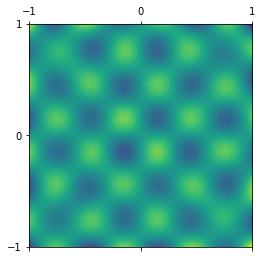

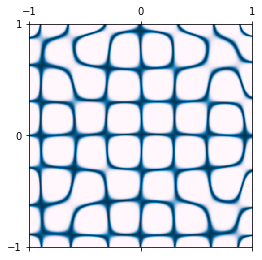

(None, None)

In [74]:
chladni_show.show_waves(v, basis_set[:5]),chladni_show.show_nodes(v,basis_set[:5])

# c. Rayleigh quotient iteration function 

## (1) 

In the following approximate solutions to linear systems are computed with the numpy.linalg.lstsq() method because the custom method shows instability for some of the example matrices. 

In [79]:
def shifted_inverse_iterate(A, x, shift):
    n = len(A)
    k = 0
    while( (not converged(x, la.lstsq(A-shift*np.eye(n), x)[0])) and (k<100)):
        k+=1
        x = la.lstsq(A-shift*np.eye(n), x)[0]
        x = x/la.norm(x)
    return x

In [87]:
def rayleigh_iterate(A, x0, shift):
    rr, k = 1, 0
    n = len(A)
    x = shifted_inverse_iterate(A,x0,shift)
    while(rr>1e-12 and (k<1000)):
        k+=1
        x = la.lstsq((A-shift*np.eye(n)),x)[0]
        x = x/la.norm(x)
        shift, rr = rayleigh_qt(A,x)
    return x, k, shift, rr

## (2) 

In [96]:
M = A_all[0]
lam, v = la.eig(M)
x0 = np.random.uniform(size = len(M))
x, k, shift, rr = rayleigh_iterate(M,x0, 4.01) 
x, shift, rr, lam

(array([-0.70710678, -0.70710678]),
 4.0,
 6.280369834735101e-16,
 array([ 4.+0.j, -2.+0.j]))

| Matrix | Rayleigh Residual | Eigenvalue|
| --- | --- | --- |
| A1 | 0.0 | -2.0 |
| A2 |  | .843 |
| A3 | Gaussian | .843 |
| A4 | Gaussian | .843 |
| A5 | Gaussian | .843 |

# d. Compute eigenvalues of K 

In [89]:
Centers, Radii = gershgorin(Kmat)

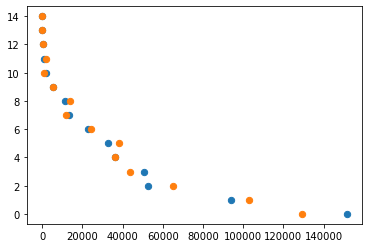

In [172]:
x = Centers
x1 = la.eig(Kmat)[0]
y = np.arange(len(x))

plt.scatter(x1,y,s=40)
plt.scatter(x,y,s=40)
plt.show()

In [124]:
Eigvalues, Eigvectors = la.eig(Kmat)
x0 = np.random.rand(len(Kmat))
Eigenvals = np.empty(shape = (len(Kmat)))
Eigenvecs = np.empty(shape = Kmat.shape)
for i in range(len(Centers)):
    Eigenvecs[:,i], k, Eigenvals[i], rr = rayleigh_iterate(Kmat, x0, Centers[i])

In [159]:
indices_sorted = np.argsort(Eigenvals)
Eigenvecs_sort = Eigenvecs[:,indices_sorted]
Eigenvals_sort = Eigenvals[indices_sorted]
x0 = np.random.rand(len(Kmat))
for i in range(len(Kmat)-1):
    lam0, lam1 = Eigenvals_sort[i], Eigenvals_sort[i+1]
    v = Eigenvecs_sort[:,i+1]
    k= 0 
    while( converged(lam0, lam1,5) and (k<1000)):
        k+=1
        v, k, lam1, rr = rayleigh_iterate(Kmat,x0, lam0+1000*k*np.random.rand())
    Eigenvals_sort[i+1] = lam1
    Eigenvecs_sort[:,i+1] = v

In [160]:
Eigenvals_sort

array([1.38926073e+01, 8.68802164e+01, 2.86533307e+02, 1.79980589e+03,
       5.56088120e+03, 1.33386223e+04, 2.25901985e+04, 2.25901985e+04,
       2.25901985e+04, 3.27789867e+04, 3.27790711e+04, 5.27662888e+04,
       5.27662888e+04, 5.27662888e+04, 5.80361990e+04])

In [177]:
v, k, lam1, rr = rayleigh_iterate(Kmat,x0, 2.25901985e+04+np.random.rand()*15000)
lam1

32779.07108348689

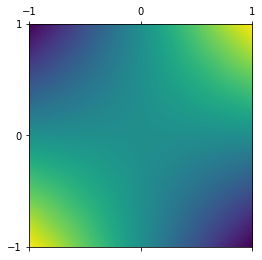

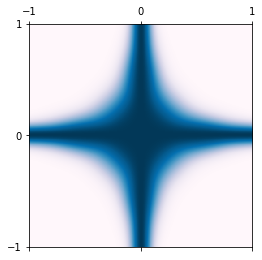

(None, None)

In [115]:
v = Eigenvecs[-1]
chladni_show.show_waves(v, basis_set),chladni_show.show_nodes(v,basis_set)